In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Importing standard dependencies**

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
import re

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reading dataset

In [2]:
dataset = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin', header=None)

In [3]:
dataset.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [4]:
tweet_data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin', header=None, usecols=[0,5], names = ['labels', 'tweets'])
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   labels  1600000 non-null  int64 
 1   tweets  1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [5]:
tweet_data.head(10)

,labels,tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [6]:
tweet_data['labels'].value_counts()

labels
0    800000
4    800000
Name: count, dtype: int64

In [7]:
tweet_data['labels'] = tweet_data['labels'].replace(4,1)

In [8]:
for i in tweet_data['tweets'][:10]:
  print(i)

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
my whole body feels itchy and like its on fire 
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
@Kwesidei not the whole crew 
Need a hug 
@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
@Tatiana_K nope they didn't have it 
@twittera que me muera ? 


In [21]:
def text_cleaner(text):
    # Identifying and removing Twitter handlers
    text = re.sub(r"@\w+"," ", text)

    # Identifying and removing URLS
    text = re.sub(r"https?://\S+|www\.\S+"," ",text)

    # Identifying removing html tags
    text = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",text)

    # Identifying and removing the Punctuation
    text = re.sub(r"[^\w\s]", " ", text)

    # Identifying and removing words that have numbers
    text = re.sub(r"\w*\d\w*", " ", text)

    # Identifying and removing Digits
    text = re.sub(r"[0-9]+", " ", text)

    # # Cleaning white spaces
    text = re.sub(r"\s+", " ", text).strip()

    text = text.lower()
    # Check stop words
    tokens = []
    for token in text.split():
        if token not in stopwords and len(token) > 3:
            tokens.append(token)
    return " ".join(tokens)

Applying the text_cleaner function to tweet_data

In [22]:
tweet_data.loc[:, 'tweets'] = tweet_data['tweets'].apply(text_cleaner)

In [23]:
tweet_data.head()

,labels,tweets
0,0,awww bummer shoulda david carr third
1,0,upset update facebook texting might result sch...
2,0,dived many times ball managed save rest bounds
3,0,whole body feels itchy like fire
4,0,behaving


Splitting the data into train and test

In [24]:
from sklearn.model_selection import train_test_split as tts
X = tweet_data['tweets']
Y = tweet_data['labels']

X_train, X_test, Y_train, Y_test = tts(X,Y, test_size=0.3, random_state=7)
print("Train Data size:", len(X_train), len(Y_train))
print("Test Data size", len(X_test), len(Y_test))

Train Data size: 1120000 1120000
Test Data size 480000 480000


Reshaping X_train and X_test

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max([len(seq) for seq in X_train])
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
print(f"After padding: {X_train.shape}")
print(f"After padding:{X_test.shape}")

After padding: (1120000, 27)
After padding:(480000, 27)


In [27]:
batch_size=512
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 100

#### **Using RNN(Recurrent Neural Network)+CNN
* CNN and FFNN is not going to be used as here we have Unstructured Data

In [29]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Embedding, Input
from tensorflow.keras import datasets,models,layers

NN=models.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.Dropout(0.5),
    
    layers.Conv1D(filters=256, kernel_size=3, activation='relu'), 
    layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')
])

NN.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [30]:
history=NN.fit(X_train, Y_train, epochs=20,batch_size=batch_size)

Epoch 1/20
  10/2188 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.5055 - loss: 0.6937

W0000 00:00:1717657564.791060     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 45s 16ms/step - accuracy: 0.7218 - loss: 0.5359
Epoch 2/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.7848 - loss: 0.4592
Epoch 3/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.8038 - loss: 0.4257
Epoch 4/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.8182 - loss: 0.3977
Epoch 5/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.8289 - loss: 0.3738
Epoch 6/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.8356 - loss: 0.3576
Epoch 7/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.8409 - loss: 0.3462
Epoch 8/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.8456 - loss: 0.3367
Epoch 9/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.8497 - loss: 0.3281
Epoch 10/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.8525 - loss: 0.3218
Epoch 11/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.8551 - loss: 0.3159
Epoch 12/20
2188/21

In [31]:
NN.evaluate(X_test, Y_test)

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.7476 - loss: 0.8232


[0.8268070220947266, 0.7472895979881287]

In [32]:
NN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 27, 100)        │    20,680,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 27, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 25, 256)        │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 23, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,961,437 (240.18 MB)

 Trainable params: 20,987,145 (80.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,974,292 (160.12 MB)

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


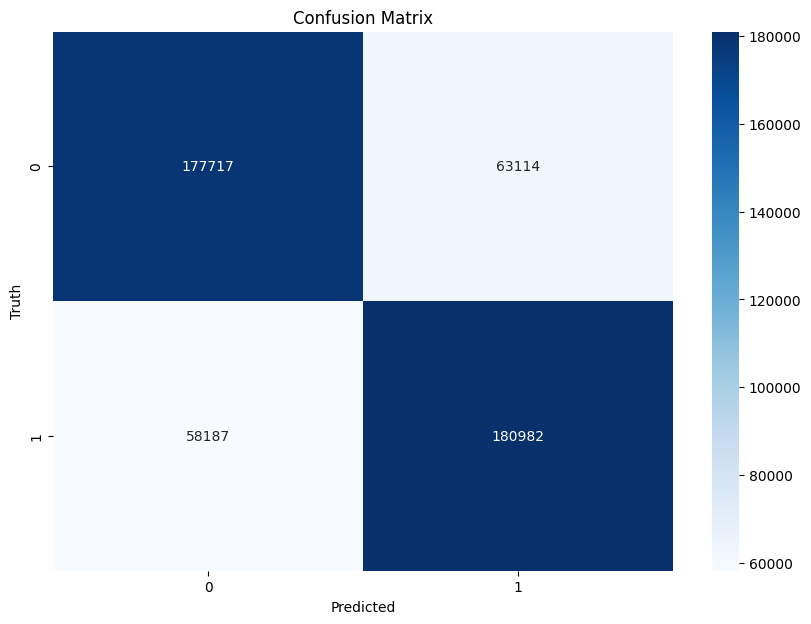

In [33]:
y_pred = NN.predict(X_test)
y_pred_rounded = np.round(y_pred)
cm = tf.math.confusion_matrix(labels=Y_test,predictions=y_pred_rounded)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [34]:
from sklearn.metrics import classification_report


# Print classification report
print(classification_report(Y_test, y_pred_rounded))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75    240831
           1       0.74      0.76      0.75    239169

    accuracy                           0.75    480000
   macro avg       0.75      0.75      0.75    480000
weighted avg       0.75      0.75      0.75    480000

